In [1]:
from __future__ import unicode_literals, print_function
%matplotlib inline
from matplotlib import  pyplot as plt
import geopandas as gpd
import svgis
from IPython.display import SVG, display, display_svg
import os

/Users/abenassi/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def show_svg(filename):
    return SVG(filename=filename)

In [91]:
def geometries_to_svg(shp_path, shps_dir, svgs_dir, 
                      id_field="departamento_id", geometry_field="geometry"):
    df = gpd.read_file(shp_path, encoding="latin1")

    # TODO: revisar esta linea ad-hoc
    df.rename(columns={"link": "departamento_id", "nombre": "departamento_nombre"}, inplace=True)

    # separa el shp en un shp y un svg para cada figura
    for i in xrange(len(df)):
        msg = "Procesando la figura {}, de, {}".format(i + 1, len(df))
        print(msg, end="\r"*len(msg))
        
        # crea el shp individual
        file_name_shp = df.loc[i, id_field] + ".shp"
        file_path_shp = os.path.join(shps_dir, file_name_shp)
        df.iloc[i:i+1].to_file(file_path_shp)
        
        # crea el svg individual
        svg = svgis.SVGIS(file_path_shp)
        file_name_svg = df.loc[i, id_field] + ".svg"
        file_path_svg = os.path.join(svgs_dir, file_name_svg)
        with open(file_path_svg, "wb") as f:
            f.write(svg.compose())

In [89]:
geometries_to_svg(
    shp_path="data/provincias/pxprovdatos.shp",
    shps_dir="data/provincias/shp", svgs_dir="data/provincias/svg"
)

KeyError: u'the label [link] is not in the [index]'

In [92]:
geometries_to_svg(
    shp_path="data/departamentos/pxdptodatos.shp",
    shps_dir="data/departamentos/shp", svgs_dir="data/departamentos/svg"
)

In [145]:
df_prov = gpd.read_file("data/provincias/pxprovdatos.shp", encoding="utf8")
df_depto = gpd.read_file("data/departamentos/pxdptodatos.shp", encoding="utf8", crs="4326")

/Users/abenassi/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


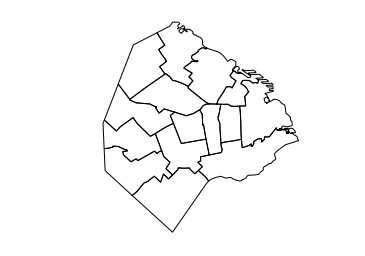

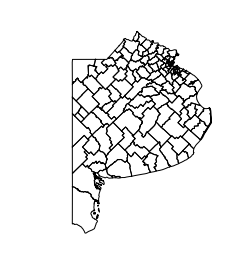

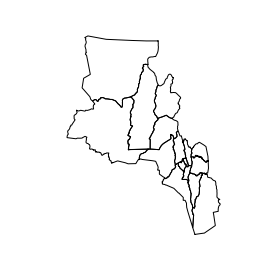

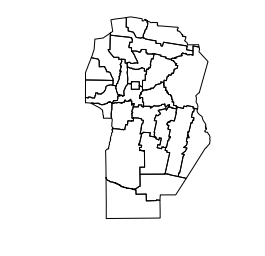

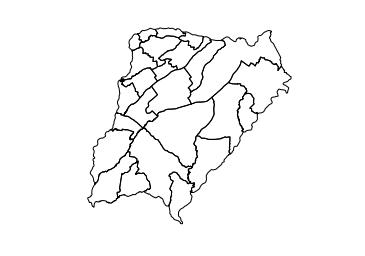

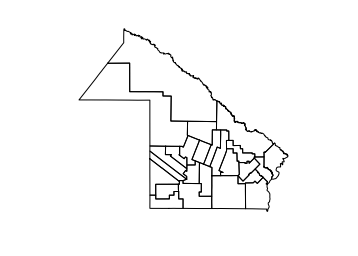

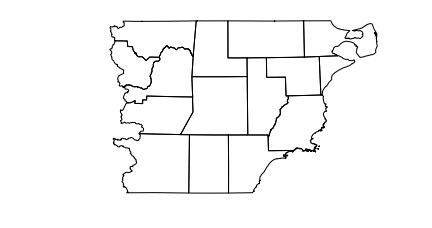

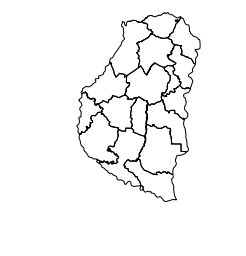

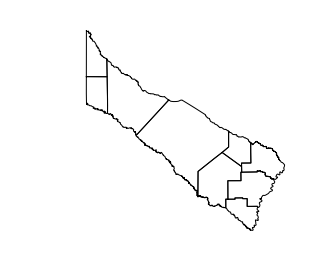

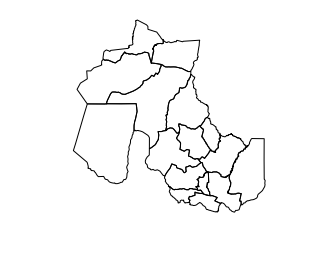

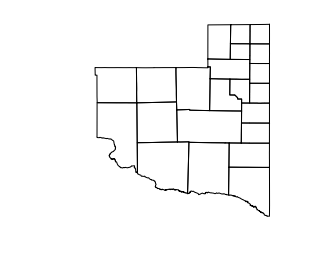

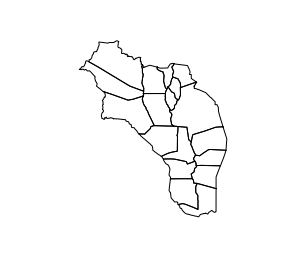

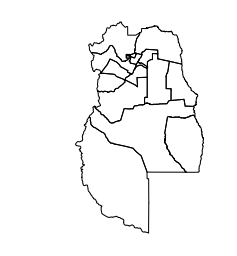

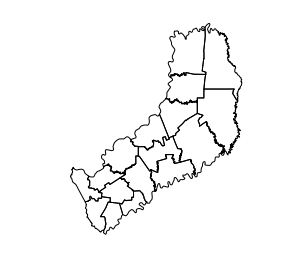

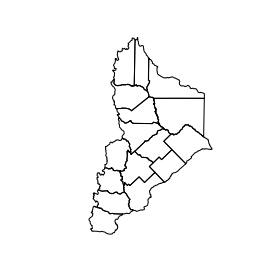

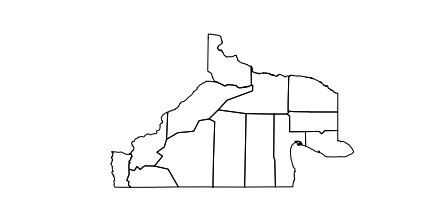

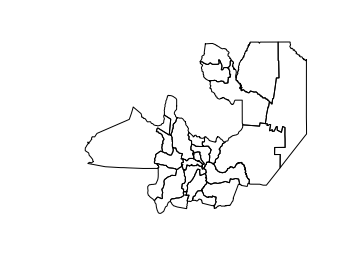

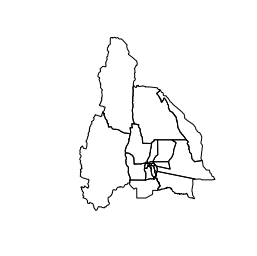

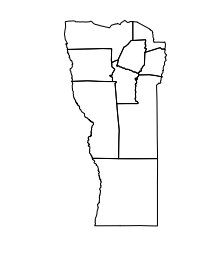

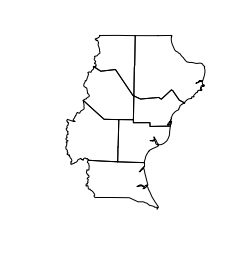

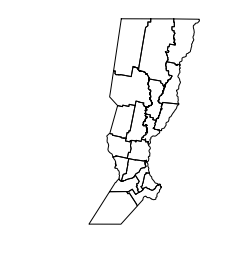

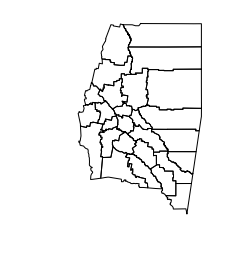

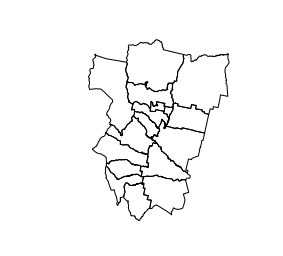

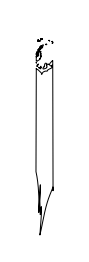

In [2]:
# mergeo en shp, y creo un svg del shp mergeado (no puedo taggear los departamentos)
df = gpd.read_file("data/departamentos/pxdptodatos.shp", encoding="utf8")
df.rename(columns={"link": "departamento_id", "nombre": "departamento_nombre"}, inplace=True)
df["provincia_id"] = df.departamento_id.str[:2]

shps_dir = "data/prov_deptos/shp"
svgs_dir = "data/prov_deptos/svg"

for provincia_id in df.provincia_id.unique():
    msg = "Procesando la figura {}".format(provincia_id)
    print(msg, end="\r"*len(msg))

    df_prov_id = df[df.provincia_id == provincia_id][["departamento_id", "departamento_nombre", "geometry"]]
        
    ax = df_prov_id.to_crs({"init": "epsg:3395"}).plot(color="white")
    ax.set_aspect("equal")
    plt.axis("off")
    for patch, departamento_id in zip(ax.patches, list(df_prov_id.departamento_id)):
        patch.set_gid(departamento_id)
    file_name_svg = provincia_id + ".svg"
    file_path_svg = os.path.join(svgs_dir, file_name_svg)
    plt.savefig(file_path_svg)

In [23]:
glob.glob("data/departamentos/shp/02*.shp")

[u'data/departamentos/shp/02001.shp',
 u'data/departamentos/shp/02002.shp',
 u'data/departamentos/shp/02003.shp',
 u'data/departamentos/shp/02004.shp',
 u'data/departamentos/shp/02005.shp',
 u'data/departamentos/shp/02006.shp',
 u'data/departamentos/shp/02007.shp',
 u'data/departamentos/shp/02008.shp',
 u'data/departamentos/shp/02009.shp',
 u'data/departamentos/shp/02010.shp',
 u'data/departamentos/shp/02011.shp',
 u'data/departamentos/shp/02012.shp',
 u'data/departamentos/shp/02013.shp',
 u'data/departamentos/shp/02014.shp',
 u'data/departamentos/shp/02015.shp']

In [94]:
with open("data/prueba.svg", "wb") as f:
    svg = svgis.SVGIS(glob.glob("data/departamentos/shp/02*.shp"), id_field="departamento_id")
    f.write(svg.compose(scalar=1/10.0))
    

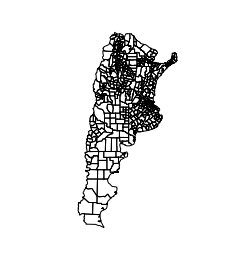

In [155]:
df_caba = df_depto[df_depto.link.str.startswith("02")]
df_caba = df_depto[~df_depto.link.str.startswith("94")]
ax = df_caba.to_crs({"init": "epsg:3395"}).plot(color="white")
ax.set_aspect("equal")
plt.axis("off")
for patch, link in zip(ax.patches, list(df_caba.link)):
    patch.set_gid(link)
plt.savefig("prueba_mec_capo.svg")

In [135]:
plt.plot()

u''

In [133]:
ax.set_aspect("equal")

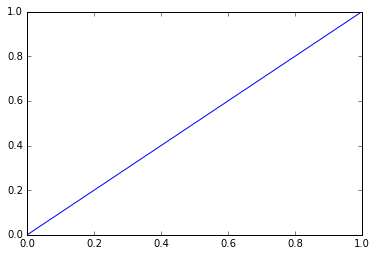

In [122]:
plt.plot([0, 1], [0, 1])
plt.savefig("prueba_mec_capo.svg")

In [98]:
svg.

u'<svg xmlns="http://www.w3.org/2000/svg" baseProfile="full" height="3931.70649237" version="1.1" viewBox="45468.864808,4057622.977575,7374.245320,3931.706492" width="7374.24532048"><defs><style type="text/css">polyline,line,rect,path,polygon,.polygon{fill:none;stroke:#000;stroke-width:1px;stroke-linejoin:round;}</style></defs><g fill_rule="evenodd" transform="scale(1,-1)"><g class="hogares departamen mujeres departam_1 toponimo_i tot_pob varones viv_part viv_part_h" id="02001"><polygon class="_02001" id="None" points="57343.7225058,-4058260.55412 58088.8977771,-4058223.02109 58090.5234564,-4058224.90046 58268.657106,-4058357.44839 58270.7439797,-4058358.79739 58270.201534,-4058429.57853 57630.6654681,-4058460.24323 57843.2636765,-4058608.32248 57848.46362,-4058611.44709 58561.3377729,-4058575.16602 58564.9811473,-4058577.4028 58701.7689638,-4058681.4471 58707.2108502,-4058752.30846 58074.4475538,-4058780.01367 58114.409783,-4058810.10647 58116.0008928,-4058811.49004 58239.6923896,-405

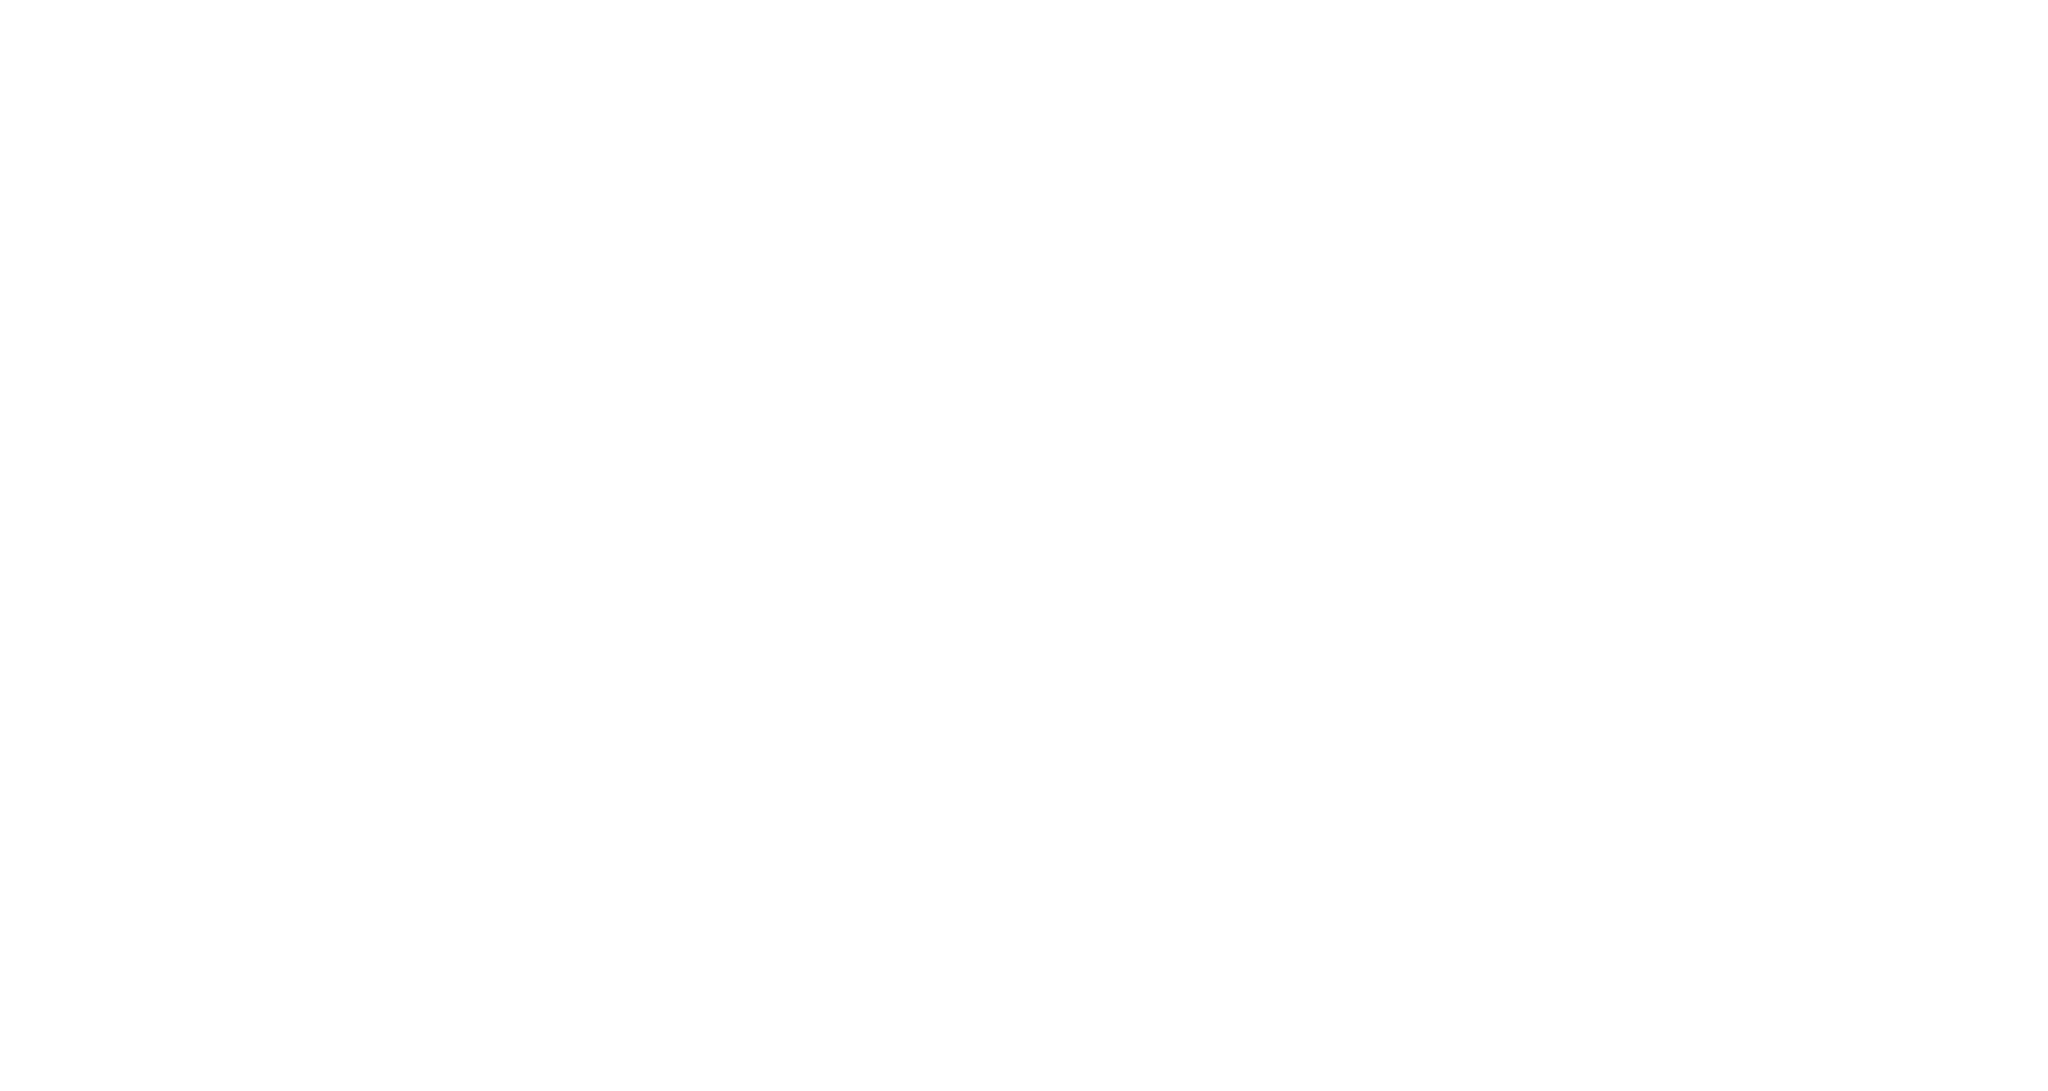

In [33]:
SVG(filename="data/prueba.svg")